# Задание 2. Скалярное произведение векторов
Необходимо найти скалярное произведение двух векторов. Для этого воспользуемся четырьмя подходами:
- Однопоточный алгоритм
- Распараллеливание по данным в цикле: 
  - С обеспечением синхронизации за счет помещения операции скалярного произведения в критическую секцию
  - С обеспечением синхронизации за счет объявления скалярного произведения атомарной операцией
  - С использованием редукции оператором `+`

## Описание подходов
Все описанные алгоритмы находятся в модуле [`dotProduct`](../../dotProduct/dotProduct.c).

### Однопоточная версия
Реализация данного подхода содержится в методе `dotProductSingleThread`. 

```c
int dotProductSingleThread(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int sum = 0;
    for (int i = 0; i < sizeA; i++)
    {
        sum += a[i] * b[i];
    }
    return sum;
}
```

### Синхронизация за счет критической секции
В данном подходе для обеспечения синхронизации потоков скалярное произведение размещено в критической секции.

```c
int dotProductWithCriticalSection(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int total = 0;
    int i;
    int chunkSize;
    int sum;
    int start;
    int end;
#pragma omp parallel shared(a, b, sizeA, chunkSize, total) private(i, sum, start, end)
    {
        chunkSize = sizeA / omp_get_num_threads();
        start = omp_get_thread_num() * chunkSize;
        end = omp_get_thread_num() == omp_get_num_threads()
                  ? sizeA
                  : start + chunkSize;
        for (i = start; i < end; i++)
        {
            sum += a[i] * b[i];
        }
#pragma omp critical
        {
            total += sum;
        }
    }

    return total;
}
```

### Синхронизация за счет атомарности
В данном подходе операция сложения помечена как атомарная.
```c
int dotProductWithAtomic(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int total = 0;
    int i;
    int chunkSize;
    int sum;
    int start;
    int end;
#pragma omp parallel shared(a, b, sizeA, chunkSize, total) private(i, sum, start, end)
    {
        chunkSize = sizeA / omp_get_num_threads();
        start = omp_get_thread_num() * chunkSize;
        end = omp_get_thread_num() == omp_get_num_threads()
                  ? sizeA
                  : start + chunkSize;
        for (i = start; i < end; i++)
        {
            sum += a[i] * b[i];
        }
#pragma omp atomic
        total += sum;
    }

    return total;
}
```

### Редукция
В данном подходе использована редукция с оператором `+`. 
```c
int dotProductWithReduction(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int sum = 0;
    int i;
#pragma omp parallel for shared(a, b, sizeA) reduction(+ \
                                                       : sum) default(none)

    for (i = 0; i < sizeA; i++)
    {
        sum += a[i] * b[i];
    }
    return sum;
}
```

## Сравнение эффективности алгоритмов
Для сравнения алгоритмов были произведены замеры времени их работы на массивах, состоящих из 100, 10000 и 10000000 элементов. Было проведено 30 экспериментов, их результаты сохранены в файле [output.csv](../build/output.csv). 
Первые 10 строк таблицы представлены ниже.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
array_sizes = {100: "small", 100000: "medium", 100000000: "large"}
dataset = dataset.astype({'method': 'category',  'array_size': 'category'})
dataset['array_size'] = dataset['array_size'].replace(array_sizes)
print(dataset.head(10))


   num_threads            method array_size  elapsed_time
0            1            single      small        0.0003
1            2  critical_section      small        0.4523
2            2            atomic      small        0.0014
3            2         reduction      small        0.0011
4            3  critical_section      small        0.0019
5            3            atomic      small        0.0011
6            3         reduction      small        0.0009
7            4  critical_section      small        0.0016
8            4            atomic      small        0.0011
9            4         reduction      small        0.0010


Рассчитаем среднее время работы каждого из описанных подходов при каждом из имеющихся размеров массивов.

In [2]:
dataset.array_size.unique()

['small', 'medium', 'large']
Categories (3, object): ['small', 'medium', 'large']

In [3]:
means_for_single_thread = dataset[dataset['method'] == 'single'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_critical_section = dataset[dataset['method'] == 'critical_section'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_atomic = dataset[dataset['method'] == 'atomic'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_reduction = dataset[dataset['method'] == 'reduction'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')

In [4]:
def visualize(ylabel, title, data):
    labels = array_sizes.keys()
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x - 3*width/2, data['single'],
                    width, label='Однопоточная версия')
    rects2 = ax.bar(x - width/2, data['critical_section'],
                    width, label='Многопоточная с критической секцией')
    rects3 = ax.bar(x + width/2, data['atomic'], width,
                    label='Многопоточная с атомарной операцией')
    rects4 = ax.bar(x + 3*width/2, data['reduction'],
                    width, label='Многопоточная с редукцией')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Размер массива')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects4, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()


Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого из доступных размеров массивов. 

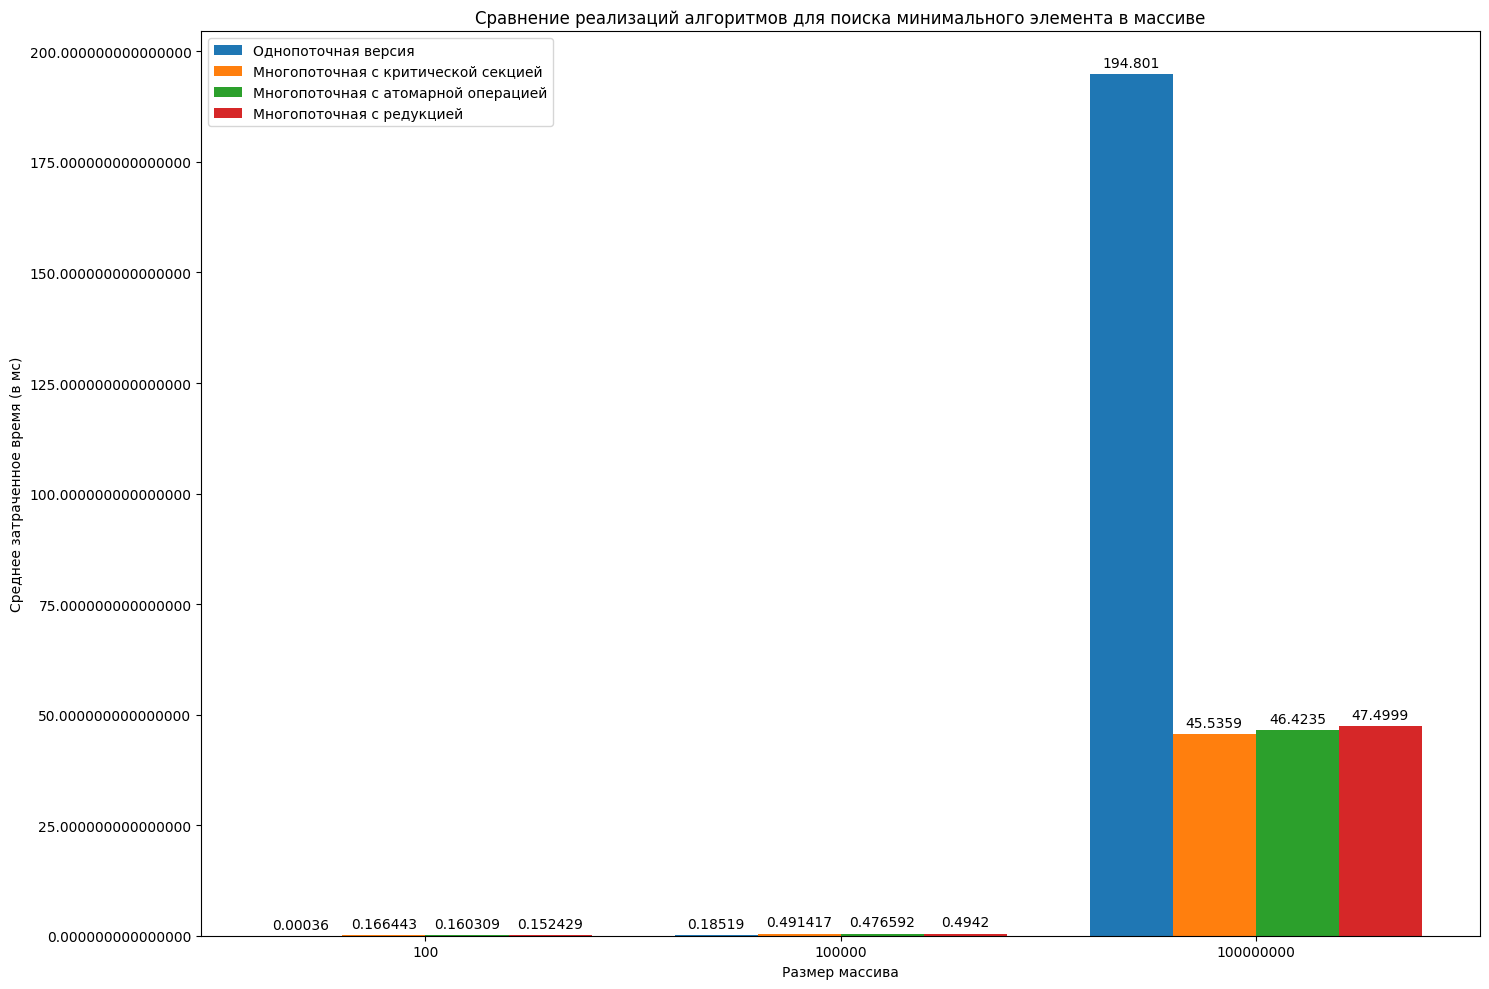

In [5]:
mean_data = dict(zip(dataset['method'].unique(), [
    means_for_single_thread['elapsed_time'], means_for_critical_section['elapsed_time'], means_for_atomic['elapsed_time'], means_for_reduction['elapsed_time']]))
visualize('Среднее затраченное время (в мс)',
          'Сравнение реализаций алгоритмов для поиска минимального элемента в массиве', mean_data)


Легко заметить, что применение многопоточности оправдано лишь массивов большого размера. Для них все 3 метода в среднем работают примерно в 4 раза быстрее, чем однопоточная программа. Далее рассмотрим зависимость ускорения от числа потоков для каждого из имеющихся размеров массивов.

In [6]:
means_for_single_thread = dataset[dataset['method'] == 'single'].groupby(
    'array_size').agg({'elapsed_time': 'mean'}).reset_index()

means_for_multhread = dataset[dataset['num_threads'] >= 2].groupby(
    ['num_threads', 'array_size', 'method']).agg({'elapsed_time': 'mean'})
means_for_multhread = means_for_multhread[means_for_multhread['elapsed_time'].notnull(
)].reset_index()


smtet = means_for_multhread[means_for_multhread['array_size']
                            == 'small']['elapsed_time']
sstet = means_for_single_thread[means_for_single_thread['array_size']
                                == 'small']['elapsed_time']
means_for_multhread.loc[means_for_multhread['array_size']
                        == 'small', 'boost'] = sstet.loc[0]/ smtet 

mmtet = means_for_multhread[means_for_multhread['array_size']
                            == 'medium']['elapsed_time']
mstet = means_for_single_thread[means_for_single_thread['array_size']
                                == 'medium']['elapsed_time']
means_for_multhread.loc[means_for_multhread['array_size']
                        == 'medium', 'boost'] = mstet.loc[1] / mmtet 

lmtet = means_for_multhread[means_for_multhread['array_size']
                            == 'large']['elapsed_time']
lstet = means_for_single_thread[means_for_single_thread['array_size']
                                == 'large']['elapsed_time']
means_for_multhread.loc[means_for_multhread['array_size']
                        == 'large', 'boost'] = lstet.loc[2] / lmtet 

In [7]:
def visualize_boost(data, filters, title):
    labels = dataset.num_threads.unique()[1:]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    bfsa_critical = plt.plot(
        x, data.loc[filters['critical'], 'boost'], label='Критическая секция')
    bfsa_atomic = plt.plot(
        x, data.loc[filters['atomic'], 'boost'], label='Атомарная операция')
    bfsa_reduction = plt.plot(
        x, data.loc[filters['reduction'], 'boost'], label='Редукция')

    ax.set_xticks(x, labels)
    ax.set_title(title)
    ax.set_xlabel('Количество потоков')
    ax.set_ylabel('Ускорение')
    ax.grid()
    ax.legend()
        

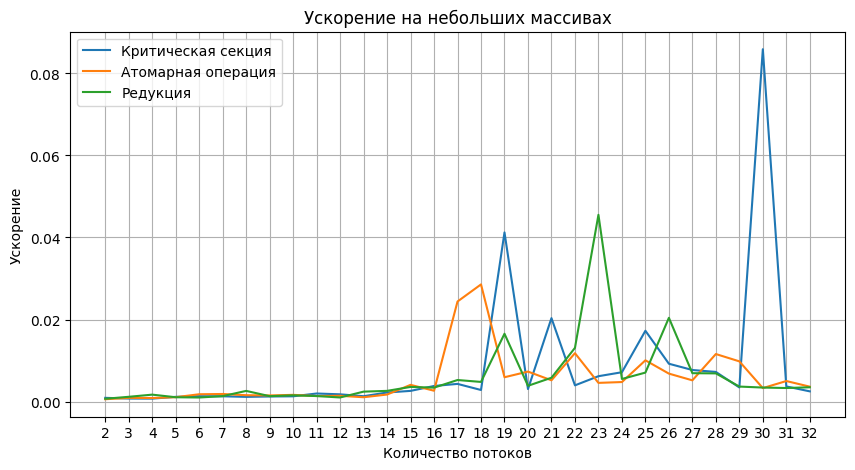

In [8]:
filters_for_small_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['array_size'] == 'small'),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['array_size'] == 'small'),
    'atomic': (means_for_multhread['method'] == 'atomic') & (means_for_multhread['array_size'] == 'small')
}
visualize_boost(means_for_multhread, filters_for_small_arrays, 'Ускорение на небольших массивах')

Как и ожидалось, на массивах небольшого размера любой алгоритм независимо от числа потоков работает более чем в 2 раза медленнее однопоточной версии. 

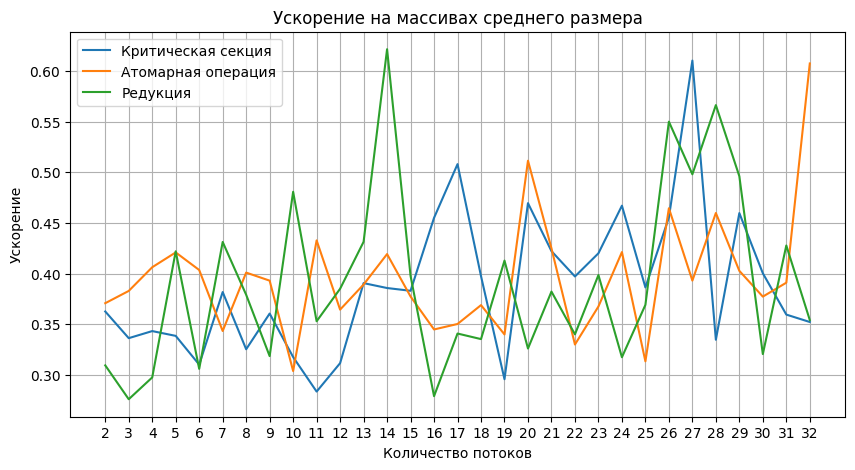

In [9]:
filters_for_medium_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['array_size'] == 'medium'),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['array_size'] == 'medium'),
    'atomic': (means_for_multhread['method'] == 'atomic') & (means_for_multhread['array_size'] == 'medium')
}
visualize_boost(means_for_multhread, filters_for_medium_arrays, 'Ускорение на массивах среднего размера')

Для массивов среднего размера получилась картина, аналогичная предыдущему случаю.

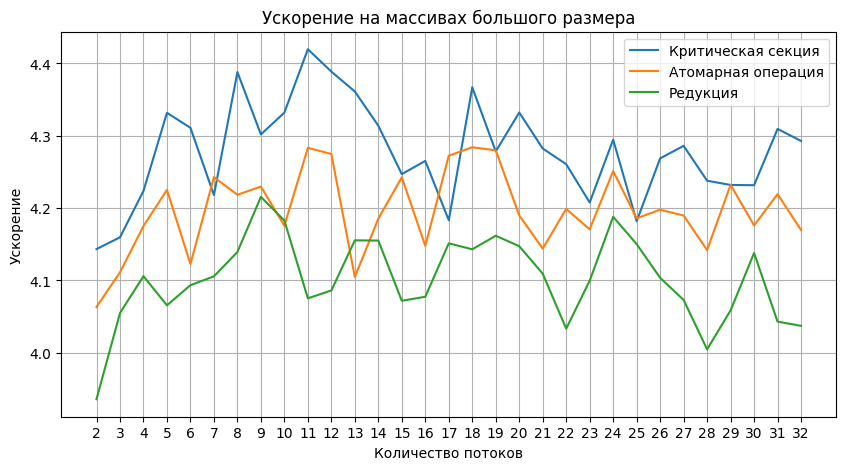

In [10]:
filters_for_large_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['array_size'] == 'large'),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['array_size'] == 'large'),
    'atomic': (means_for_multhread['method'] == 'atomic') & (means_for_multhread['array_size'] == 'large')
}
visualize_boost(means_for_multhread, filters_for_large_arrays,
                'Ускорение на массивах большого размера')


Для больших массивов любой из методов показывает себя более, чем в 3 раза эффективнее однопоточной версии. Однако максимального ускорения получается добиться за счет использования метода с критической секцией и 11 потоков.